In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpyro as npr
import numpyro.distributions as dist
from jax import random

# Plots
linewidth = 8
SMALL_SIZE = 15.74
NORMAL_SIZE = 24.88
LARGE_SIZE = 35.83

plt.style.use('seaborn-whitegrid')
sns.set_palette("tab10")
plt.rcParams['font.size'] = NORMAL_SIZE
plt.rcParams['axes.labelsize'] = NORMAL_SIZE
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = NORMAL_SIZE
plt.rcParams['ytick.labelsize'] = NORMAL_SIZE
plt.rcParams['legend.fontsize'] = SMALL_SIZE
plt.rcParams['figure.titlesize'] = LARGE_SIZE
plt.rcParams['axes.axisbelow'] = True

# Latex

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['lines.linewidth'] = 3

import tikzplotlib

In [2]:
# Prior
def sample_prior(n_samples):
    rng_keys = random.split(random.PRNGKey(1), 2)
    mu = npr.sample('mu', dist.Normal(0, 1), sample_shape=(n_samples, 1), rng_key=rng_keys[0])
    sigma_sq = npr.sample('sigma_sq', dist.Gamma(1, 1), sample_shape=(n_samples, 1), rng_key=rng_keys[1])
    theta = np.concatenate((mu, sigma_sq), axis=-1)
    return theta

In [3]:
# Load data
thetas_prior = sample_prior(n_samples=10000)
thetas_approx = np.load(f'../res/abc/laplace_approx.npy').squeeze()

mu_true, sigma_sq_true = thetas_prior[:, 0], thetas_prior[:, 1]
mu_approx, sigma_sq_approx = thetas_approx[:, 0], thetas_approx[:, 1]

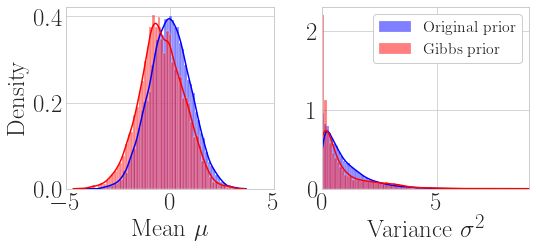

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(linewidth, .5*linewidth))

sns.histplot(mu_true, ax=axs[0], label='Prior', color='blue', kde=True, stat='density', edgecolor="white")
sns.histplot(mu_approx, ax=axs[0], label='Gibbs prior', color='red', kde=True, stat='density', edgecolor="white")
axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_xlim((-5, 5))
# axs[0].legend()

sns.histplot(sigma_sq_true, stat='density', ax=axs[1], label=r'Original prior', color='blue', kde=True, edgecolor="white")
sns.histplot(np.clip(sigma_sq_approx, a_min=0, a_max=10), stat='density', ax=axs[1], color='red',
             label=r'Gibbs prior', kde=True, edgecolor="white")
# axs[1].legend()
axs[1].set_xlim([0, 9])

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')

plt.legend(framealpha=1, frameon=True)
plt.tight_layout()
tikzplotlib.save('../fig/prior_vs_laplace.tex')
plt.show()

# Stochastic monotonicity

In [13]:
def position_in_sorted(t, sorted_vec):
    """Position of value t in the sorted vector sorted_list."""
    pos = 0
    for i in range(len(sorted_vec)):
        if t <= sorted_vec[i]:
            break
        else:
            pos += 1
    return pos

def get_cdf_val(t, sorted_vec):
    return position_in_sorted(t, sorted_vec) / len(sorted_vec)

In [15]:
mu_true_sorted, sigma_sq_true_sorted = np.sort(thetas_prior[:, 0]), np.sort(thetas_prior[:, 1])
mu_approx_sorted, sigma_sq_approx_sorted = np.sort(thetas_approx[:, 0]), np.sort(thetas_approx[:, 1])

ts_mu = np.linspace(-5, 5, 500)
ts_sigma_sq = np.linspace(0, 9, 500)

mu_true_cdf = [get_cdf_val(t, mu_true_sorted) for t in ts_mu]
mu_approx_cdf = [get_cdf_val(t, mu_approx_sorted) for t in ts_mu]
sigma_sq_true_cdf = [get_cdf_val(t, sigma_sq_true_sorted) for t in ts_sigma_sq]
sigma_sq_approx_cdf = [get_cdf_val(t, sigma_sq_approx_sorted) for t in ts_sigma_sq]

In [50]:
sigma_sq_maks = [sigma_sq_true_cdf[i] >= sigma_sq_approx_cdf[i] for i in range(len(ts_sigma_sq))]
t_equal_cdf = np.round(ts_sigma_sq[sigma_sq_maks][1], 2)
t_val_equal_cdf = np.round(np.array(sigma_sq_true_cdf)[sigma_sq_maks][1], 2)
print(f'The cdfs for the variance coincide at t={np.round(t_equal_cdf, 2)} with a value of F(t)={np.round(t_val_equal_cdf, 2)}')

The cdfs for the variance coincide at t=1.48 with a value of F(t)=0.77


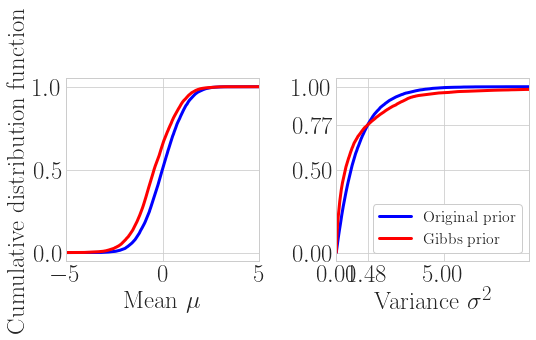

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(linewidth, .5*linewidth))

# Means cdf
axs[0].plot(ts_mu, mu_true_cdf, label='Original prior', color='blue')
axs[0].plot(ts_mu, mu_approx_cdf, label='Gibbs prior', color='red')

axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_ylabel(r'Cumulative distribution function')
axs[0].set_xlim((-5, 5))
axs[0].set_yticks([0, .5, 1])

# Variances cdf
axs[1].plot(ts_sigma_sq, sigma_sq_true_cdf, label='Original prior', color='blue')
axs[1].plot(ts_sigma_sq, sigma_sq_approx_cdf, label='Gibbs prior', color='red')

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')
axs[1].set_xlim([0, 9])
axs[1].set_xticks([0,  t_equal_cdf, 5])
axs[1].set_yticks([0, .5, t_val_equal_cdf, 1])

plt.legend(framealpha=1, frameon=True, loc='lower right')
plt.tight_layout()
tikzplotlib.save('../fig/prior_vs_laplace_cdf.tex')
plt.show()